# Model with segmentation and augmentation

## Imports

In [13]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split

from  PIL import Image

from elle_ebene.utils.simple_preprocessing import get_images, to_numpy_rgb, squared_imgs, create_dataset
from elle_ebene.hair_segmentation.hair_seg import HairSegmenter

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras import regularizers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [2]:
type3_imgs = get_images("Type 3",resizing_dim=224)
type4_imgs = get_images("Type 4",resizing_dim=224)

In [3]:
type3_imgs_rgb = to_numpy_rgb(type3_imgs)
type4_imgs_rgb = to_numpy_rgb(type4_imgs)

In [4]:
type3_imgs_squared = squared_imgs(type3_imgs_rgb)
type4_imgs_squared = squared_imgs(type4_imgs_rgb)

In [7]:
segmenter = HairSegmenter()
segmenter.model_init()

In [8]:
hairs_type3 = segmenter.get_hairs(type3_imgs_squared)
hairs_type4 = segmenter.get_hairs(type4_imgs_squared)

In [9]:
type3_labels = np.full((len(hairs_type3),),3)
type4_labels = np.full((len(hairs_type4),),4)

In [12]:
X, y = create_dataset([hairs_type3, hairs_type4], [type3_labels, type4_labels])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Data augmentation

In [14]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
    ) 

datagen.fit(X_train)

In [15]:
X_augmented_iterator = datagen.flow(X_train, shuffle=True, batch_size=1)

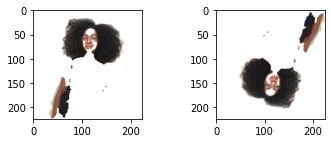

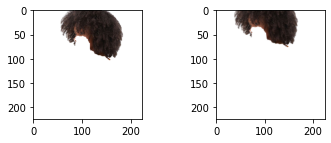

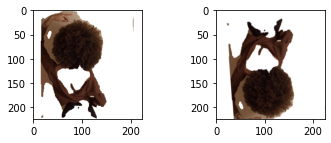

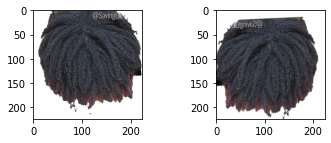

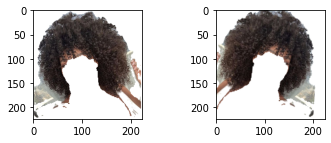

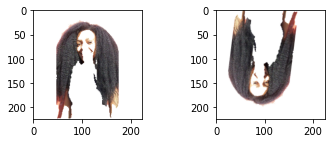

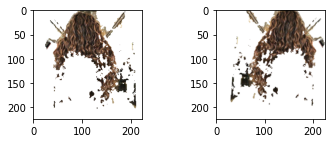

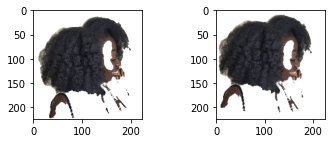

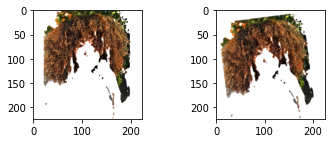

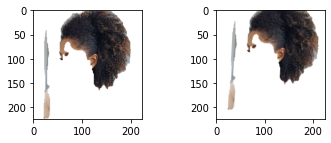

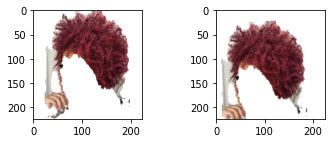

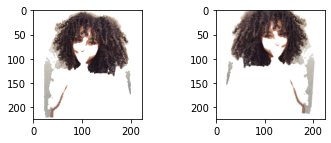

In [17]:
for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow(raw_image)
    ax2.imshow(augmented_image[0].astype("uint8"))
    plt.show()
    
    if i > 10:
        break

## Normalisation et encoding

In [18]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [19]:
y_train = to_categorical(y_train,5)[:,-2:]
y_val = to_categorical(y_val,5)[:,-2:]
y_test = to_categorical(y_test,5)[:,-2:]

## Model

In [20]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [54]:
def initialize_model():
   
    model  = models.Sequential()
    
    ### First convolution & max-pooling
    model.add(layers.Conv2D(9, kernel_size=(4, 4), activation='relu', input_shape=(224, 224, 3), padding = "same"))
    #model.add(layers.Dropout(rate=0.2))
    
    ### Second convolution
    model.add(layers.Conv2D(9, kernel_size=(3, 3), activation='relu', padding = "same"))
    model.add(layers.MaxPool2D(pool_size = (4,4)))    
    #model.add(layers.Dropout(rate=0.2))
    
    ### Third convolution
    model.add(layers.Conv2D(18, kernel_size=(3, 3), activation='relu', padding = "same"))  
    #model.add(layers.Dropout(rate=0.2))
    
    ### Fourth convolution
    model.add(layers.Conv2D(18, kernel_size=(3, 3), activation='relu', padding = "same"))
    model.add(layers.MaxPool2D(pool_size = (4,4)))    
    #model.add(layers.Dropout(rate=0.2))
    
    ### Flattening
    model.add(layers.Flatten())
    
    ### One fully connected
    model.add(layers.Dense(18, activation='relu')) 
    #model.add(layers.Dropout(rate=0.4))

    ### Last layer
    model.add(layers.Dense(2, activation='sigmoid')) 

    model.compile(loss='binary_crossentropy',
            optimizer=optimizers.Adam(learning_rate = 0.001),
            metrics=['accuracy'])
    
    return model

In [55]:
model = initialize_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 224, 224, 9)       441       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 224, 224, 9)       738       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 9)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 56, 56, 18)        1476      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 56, 56, 18)        2934      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 18)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3528)             

In [56]:
# learning rate schedule
def step_decay(epoch, lr):
    decay = 0.5
    lr *= (1. / (1. + decay * epoch))
    return lr

In [57]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor = "val_loss")
lrate = LearningRateScheduler(step_decay)
callbacks_list = [es]
train_flow = datagen.flow(X_train, y_train, batch_size=16)
history = model.fit(train_flow, validation_data = (X_val, y_val),
          epochs=200, batch_size=None, verbose=1, callbacks = callbacks_list)

Epoch 1/200
17/17 [==============================] - 6s 350ms/step - loss: 0.6989 - accuracy: 0.4542 - val_loss: 0.6900 - val_accuracy: 0.5909
Epoch 2/200
17/17 [==============================] - 6s 348ms/step - loss: 0.6908 - accuracy: 0.5382 - val_loss: 0.6854 - val_accuracy: 0.6667
Epoch 3/200
17/17 [==============================] - 7s 425ms/step - loss: 0.6877 - accuracy: 0.5534 - val_loss: 0.6751 - val_accuracy: 0.7273
Epoch 4/200
17/17 [==============================] - 7s 375ms/step - loss: 0.6781 - accuracy: 0.6107 - val_loss: 0.6668 - val_accuracy: 0.6515
Epoch 5/200
17/17 [==============================] - 7s 391ms/step - loss: 0.6658 - accuracy: 0.6221 - val_loss: 0.6344 - val_accuracy: 0.6818
Epoch 6/200
17/17 [==============================] - 7s 387ms/step - loss: 0.6651 - accuracy: 0.6298 - val_loss: 0.6192 - val_accuracy: 0.6364
Epoch 7/200
17/17 [==============================] - 7s 388ms/step - loss: 0.6423 - accuracy: 0.6450 - val_loss: 0.6183 - val_accuracy: 0.7576

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

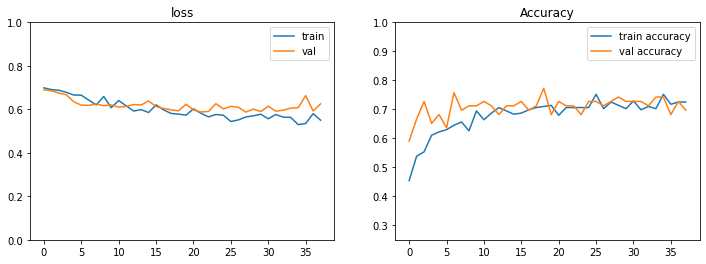

In [58]:
plot_history(history)

In [59]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 110ms/step - loss: 0.5108 - accuracy: 0.7317


[0.5108475089073181, 0.7317073345184326]